The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 概率
:label:`sec_prob`

简单地说，机器学习就是做出预测。

根据病人的临床病史，我们可能想预测他们在下一年心脏病发作的*概率*。
在飞机喷气发动机的异常检测中，我们想要评估一组发动机读数为正常运行情况的概率有多大。
在强化学习中，我们希望智能体（agent）能在一个环境中智能地行动。
这意味着我们需要考虑在每种可行的行为下获得高奖励的概率。
当我们建立推荐系统时，我们也需要考虑概率。
例如，假设我们为一家大型在线书店工作，我们可能希望估计某些用户购买特定图书的概率。
为此，我们需要使用概率学。
有完整的课程、专业、论文、职业、甚至院系，都致力于概率学的工作。
所以很自然地，我们在这部分的目标不是教授你整个科目。
相反，我们希望教给你在基础的概率知识，使你能够开始构建你的第一个深度学习模型，
以便你可以开始自己探索它。

现在让我们更认真地考虑第一个例子：根据照片区分猫和狗。
这听起来可能很简单，但对于机器却可能是一个艰巨的挑战。
首先，问题的难度可能取决于图像的分辨率。

![不同分辨率的图像 ($10 \times 10$, $20 \times 20$, $40 \times 40$, $80 \times 80$, 和 $160 \times 160$ pixels)](../img/cat-dog-pixels.png)
:width:`300px`
:label:`fig_cat_dog`

如 :numref:`fig_cat_dog`所示，虽然人类很容易以$160 \times 160$像素的分辨率识别猫和狗，
但它在$40\times40$像素上变得具有挑战性，而且在$10 \times 10$像素下几乎是不可能的。
换句话说，我们在很远的距离（从而降低分辨率）区分猫和狗的能力可能会变为猜测。
概率给了我们一种正式的途径来说明我们的确定性水平。
如果我们完全肯定图像是一只猫，我们说标签$y$是"猫"的*概率*，表示为$P(y=$"猫"$)$等于$1$。
如果我们没有证据表明$y=$“猫”或$y=$“狗”，那么我们可以说这两种可能性是相等的，
即$P(y=$"猫"$)=P(y=$"狗"$)=0.5$。
如果我们不十分确定图像描绘的是一只猫，我们可以将概率赋值为$0.5<P(y=$"猫"$)<1$。

现在考虑第二个例子：给出一些天气监测数据，我们想预测明天北京下雨的概率。
如果是夏天，下雨的概率是0.5。

在这两种情况下，我们都不确定结果，但这两种情况之间有一个关键区别。
在第一种情况中，图像实际上是狗或猫二选一。
在第二种情况下，结果实际上是一个随机的事件。
因此，概率是一种灵活的语言，用于说明我们的确定程度，并且它可以有效地应用于广泛的领域中。

## 基本概率论

假设我们掷骰子，想知道看到1的几率有多大，而不是看到另一个数字。
如果骰子是公平的，那么所有六个结果$\{1, \ldots, 6\}$都有相同的可能发生，
因此我们可以说$1$发生的概率为$\frac{1}{6}$。

然而现实生活中，对于我们从工厂收到的真实骰子，我们需要检查它是否有瑕疵。
检查骰子的唯一方法是多次投掷并记录结果。
对于每个骰子，我们将观察到$\{1, \ldots, 6\}$中的一个值。
对于每个值，一种自然的方法是将它出现的次数除以投掷的总次数，
即此*事件*（event）概率的*估计值*。
*大数定律*（law of large numbers）告诉我们：
随着投掷次数的增加，这个估计值会越来越接近真实的潜在概率。
让我们用代码试一试！

首先，我们导入必要的软件包。


In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from d2l import tensorflow as d2l

在统计学中，我们把从概率分布中抽取样本的过程称为*抽样*（sampling）。
笼统来说，可以把*分布*（distribution）看作是对事件的概率分配，
稍后我们将给出的更正式定义。
将概率分配给一些离散选择的分布称为*多项分布*（multinomial distribution）。

为了抽取一个样本，即掷骰子，我们只需传入一个概率向量。
输出是另一个相同长度的向量：它在索引$i$处的值是采样结果中$i$出现的次数。


In [2]:
fair_probs = tf.ones(6) / 6
tfp.distributions.Multinomial(1, fair_probs).sample()

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0.], dtype=float32)>

在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。
如果用Python的for循环来完成这个任务，速度会慢得惊人。
因此我们使用深度学习框架的函数同时抽取多个样本，得到我们想要的任意形状的独立样本数组。


In [3]:
tfp.distributions.Multinomial(10, fair_probs).sample()

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([3., 2., 1., 2., 1., 1.], dtype=float32)>

现在我们知道如何对骰子进行采样，我们可以模拟1000次投掷。
然后，我们可以统计1000次投掷后，每个数字被投中了多少次。
具体来说，我们计算相对频率，以作为真实概率的估计。


In [4]:
counts = tfp.distributions.Multinomial(1000, fair_probs).sample()
counts / 1000

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0.175, 0.154, 0.192, 0.155, 0.154, 0.17 ], dtype=float32)>

因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率$\frac{1}{6}$，
大约是$0.167$，所以上面输出的估计值看起来不错。

我们也可以看到这些概率如何随着时间的推移收敛到真实概率。
让我们进行500组实验，每组抽取10个样本。


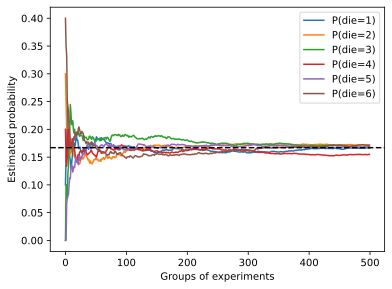

In [5]:
counts = tfp.distributions.Multinomial(10, fair_probs).sample(500)
cum_counts = tf.cumsum(counts, axis=0)
estimates = cum_counts / tf.reduce_sum(cum_counts, axis=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。
当我们通过更多的实验获得更多的数据时，这$6$条实体曲线向真实概率收敛。

### 概率论公理

在处理骰子掷出时，我们将集合$\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$
称为*样本空间*（sample space）或*结果空间*（outcome space），
其中每个元素都是*结果*（outcome）。
*事件*（event）是一组给定样本空间的随机结果。
例如，“看到$5$”（$\{5\}$）和“看到奇数”（$\{1, 3, 5\}$）都是掷出骰子的有效事件。
注意，如果一个随机实验的结果在$\mathcal{A}$中，则事件$\mathcal{A}$已经发生。
也就是说，如果投掷出$3$点，因为$3 \in \{1, 3, 5\}$，我们可以说，“看到奇数”的事件发生了。

*概率*（probability）可以被认为是将集合映射到真实值的函数。
在给定的样本空间$\mathcal{S}$中，事件$\mathcal{A}$的概率，
表示为$P(\mathcal{A})$，满足以下属性：

* 对于任意事件$\mathcal{A}$，其概率从不会是负数，即$P(\mathcal{A}) \geq 0$；
* 整个样本空间的概率为$1$，即$P(\mathcal{S}) = 1$；
* 对于*互斥*（mutually exclusive）事件（对于所有$i \neq j$都有$\mathcal{A}_i \cap \mathcal{A}_j = \emptyset$）的任意一个可数序列$\mathcal{A}_1, \mathcal{A}_2, \ldots$，序列中任意一个事件发生的概率等于它们各自发生的概率之和，即$P(\bigcup_{i=1}^{\infty} \mathcal{A}_i) = \sum_{i=1}^{\infty} P(\mathcal{A}_i)$。

以上也是概率论的公理，由科尔莫戈罗夫于1933年提出。
有了这个公理系统，我们可以避免任何关于随机性的哲学争论；
相反，我们可以用数学语言严格地推理。
例如，假设事件$\mathcal{A}_1$为整个样本空间，
且当所有$i > 1$时的$\mathcal{A}_i = \emptyset$，
那么我们可以证明$P(\emptyset) = 0$，即不可能发生事件的概率是$0$。

### 随机变量

在我们掷骰子的随机实验中，我们引入了*随机变量*（random variable）的概念。
随机变量几乎可以是任何数量，并且它可以在随机实验的一组可能性中取一个值。
考虑一个随机变量$X$，其值在掷骰子的样本空间$\mathcal{S}=\{1,2,3,4,5,6\}$中。
我们可以将事件“看到一个$5$”表示为$\{X=5\}$或$X=5$，
其概率表示为$P(\{X=5\})$或$P(X=5)$。
通过$P(X=a)$，我们区分了随机变量$X$和$X$可以采取的值（例如$a$）。
然而，这可能会导致繁琐的表示。
为了简化符号，一方面，我们可以将$P(X)$表示为随机变量$X$上的*分布*（distribution）：
分布告诉我们$X$获得某一值的概率。
另一方面，我们可以简单用$P(a)$表示随机变量取值$a$的概率。
由于概率论中的事件是来自样本空间的一组结果，因此我们可以为随机变量指定值的可取范围。
例如，$P(1 \leq X \leq 3)$表示事件$\{1 \leq X \leq 3\}$，
即$\{X = 1, 2, \text{or}, 3\}$的概率。
等价地，$P(1 \leq X \leq 3)$表示随机变量$X$从$\{1, 2, 3\}$中取值的概率。

请注意，*离散*（discrete）随机变量（如骰子的每一面）
和*连续*（continuous）随机变量（如人的体重和身高）之间存在微妙的区别。
现实生活中，测量两个人是否具有完全相同的身高没有太大意义。
如果我们进行足够精确的测量，你会发现这个星球上没有两个人具有完全相同的身高。
在这种情况下，询问某人的身高是否落入给定的区间，比如是否在1.79米和1.81米之间更有意义。
在这些情况下，我们将这个看到某个数值的可能性量化为*密度*（density）。
高度恰好为1.80米的概率为0，但密度不是0。
在任何两个不同高度之间的区间，我们都有非零的概率。
在本节的其余部分中，我们将考虑离散空间中的概率。
对于连续随机变量的概率，你可以参考深度学习数学附录中[随机变量](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/random-variables.html)
的一节。

## 处理多个随机变量

很多时候，我们会考虑多个随机变量。
比如，我们可能需要对疾病和症状之间的关系进行建模。
给定一个疾病和一个症状，比如“流感”和“咳嗽”，以某个概率存在或不存在于某个患者身上。
我们需要估计这些概率以及概率之间的关系，以便我们可以运用我们的推断来实现更好的医疗服务。

再举一个更复杂的例子：图像包含数百万像素，因此有数百万个随机变量。
在许多情况下，图像会附带一个*标签*（label），标识图像中的对象。
我们也可以将标签视为一个随机变量。
我们甚至可以将所有元数据视为随机变量，例如位置、时间、光圈、焦距、ISO、对焦距离和相机类型。
所有这些都是联合发生的随机变量。
当我们处理多个随机变量时，会有若干个变量是我们感兴趣的。

### 联合概率

第一个被称为*联合概率*（joint probability）$P(A=a,B=b)$。
给定任意值$a$和$b$，联合概率可以回答：$A=a$和$B=b$同时满足的概率是多少？
请注意，对于任何$a$和$b$的取值，$P(A = a, B=b) \leq P(A=a)$。
这点是确定的，因为要同时发生$A=a$和$B=b$，$A=a$就必须发生，$B=b$也必须发生（反之亦然）。因此，$A=a$和$B=b$同时发生的可能性不大于$A=a$或是$B=b$单独发生的可能性。

### 条件概率

联合概率的不等式带给我们一个有趣的比率：
$0 \leq \frac{P(A=a, B=b)}{P(A=a)} \leq 1$。
我们称这个比率为*条件概率*（conditional probability），
并用$P(B=b \mid A=a)$表示它：它是$B=b$的概率，前提是$A=a$已发生。

### 贝叶斯定理

使用条件概率的定义，我们可以得出统计学中最有用的方程之一：
*Bayes定理*（Bayes' theorem）。
根据*乘法法则*（multiplication rule ）可得到$P(A, B) = P(B \mid A) P(A)$。
根据对称性，可得到$P(A, B) = P(A \mid B) P(B)$。
假设$P(B)>0$，求解其中一个条件变量，我们得到

$$P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}.$$

请注意，这里我们使用紧凑的表示法：
其中$P(A, B)$是一个*联合分布*（joint distribution），
$P(A \mid B)$是一个*条件分布*（conditional distribution）。
这种分布可以在给定值$A = a, B=b$上进行求值。

### 边际化

为了能进行事件概率求和，我们需要*求和法则*（sum rule），
即$B$的概率相当于计算$A$的所有可能选择，并将所有选择的联合概率聚合在一起：

$$P(B) = \sum_{A} P(A, B),$$

这也称为*边际化*（marginalization）。
边际化结果的概率或分布称为*边际概率*（marginal probability）
或*边际分布*（marginal distribution）。

### 独立性

另一个有用属性是*依赖*（dependence）与*独立*（independence）。
如果两个随机变量$A$和$B$是独立的，意味着事件$A$的发生跟$B$事件的发生无关。
在这种情况下，统计学家通常将这一点表述为$A \perp  B$。
根据贝叶斯定理，马上就能同样得到$P(A \mid B) = P(A)$。
在所有其他情况下，我们称$A$和$B$依赖。
比如，两次连续抛出一个骰子的事件是相互独立的。
相比之下，灯开关的位置和房间的亮度并不是（因为可能存在灯泡坏掉、电源故障，或者开关故障）。

由于$P(A \mid B) = \frac{P(A, B)}{P(B)} = P(A)$等价于$P(A, B) = P(A)P(B)$，
因此两个随机变量是独立的，当且仅当两个随机变量的联合分布是其各自分布的乘积。
同样地，给定另一个随机变量$C$时，两个随机变量$A$和$B$是*条件独立的*（conditionally independent），
当且仅当$P(A, B \mid C) = P(A \mid C)P(B \mid C)$。
这个情况表示为$A \perp B \mid C$。

### 应用
:label:`subsec_probability_hiv_app`

我们实战演练一下！
假设一个医生对患者进行艾滋病病毒（HIV）测试。
这个测试是相当准确的，如果患者健康但测试显示他患病，这个概率只有1%；
如果患者真正感染HIV，它永远不会检测不出。
我们使用$D_1$来表示诊断结果（如果阳性，则为$1$，如果阴性，则为$0$），
$H$来表示感染艾滋病病毒的状态（如果阳性，则为$1$，如果阴性，则为$0$）。
在 :numref:`conditional_prob_D1`中列出了这样的条件概率。

:条件概率为$P(D_1 \mid H)$

| 条件概率 | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_1 = 1 \mid H)$|            1 |         0.01 |
|$P(D_1 = 0 \mid H)$|            0 |         0.99 |
:label:`conditional_prob_D1`

请注意，每列的加和都是1（但每行的加和不是），因为条件概率需要总和为1，就像概率一样。
让我们计算如果测试出来呈阳性，患者感染HIV的概率，即$P(H = 1 \mid D_1 = 1)$。
显然，这将取决于疾病有多常见，因为它会影响错误警报的数量。
假设人口总体是相当健康的，例如，$P(H=1) = 0.0015$。
为了应用贝叶斯定理，我们需要运用边际化和乘法法则来确定

$$\begin{aligned}
&P(D_1 = 1) \\
=& P(D_1=1, H=0) + P(D_1=1, H=1)  \\
=& P(D_1=1 \mid H=0) P(H=0) + P(D_1=1 \mid H=1) P(H=1) \\
=& 0.011485.
\end{aligned}
$$

因此，我们得到

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1)\\ =& \frac{P(D_1=1 \mid H=1) P(H=1)}{P(D_1=1)} \\ =& 0.1306 \end{aligned}.$$

换句话说，尽管使用了非常准确的测试，患者实际上患有艾滋病的几率只有13.06%。
正如我们所看到的，概率可能是违反直觉的。

患者在收到这样可怕的消息后应该怎么办？
很可能，患者会要求医生进行另一次测试来确定病情。
第二个测试具有不同的特性，它不如第一个测试那么精确，
如 :numref:`conditional_prob_D2`所示。

:条件概率为$P(D_2 \mid H)$

| 条件概率 | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_2 = 1 \mid H)$|            0.98 |         0.03 |
|$P(D_2 = 0 \mid H)$|            0.02 |         0.97 |
:label:`conditional_prob_D2`

不幸的是，第二次测试也显示阳性。让我们通过假设条件独立性来计算出应用Bayes定理的必要概率：

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 0) \\
=& P(D_1 = 1 \mid H = 0) P(D_2 = 1 \mid H = 0)  \\
=& 0.0003,
\end{aligned}
$$

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 1) \\
=& P(D_1 = 1 \mid H = 1) P(D_2 = 1 \mid H = 1)  \\
=& 0.98.
\end{aligned}
$$

现在我们可以应用边际化和乘法规则：

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1) \\
=& P(D_1 = 1, D_2 = 1, H = 0) + P(D_1 = 1, D_2 = 1, H = 1)  \\
=& P(D_1 = 1, D_2 = 1 \mid H = 0)P(H=0) + P(D_1 = 1, D_2 = 1 \mid H = 1)P(H=1)\\
=& 0.00176955.
\end{aligned}
$$

最后，鉴于存在两次阳性检测，患者患有艾滋病的概率为

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1, D_2 = 1)\\
=& \frac{P(D_1 = 1, D_2 = 1 \mid H=1) P(H=1)}{P(D_1 = 1, D_2 = 1)} \\
=& 0.8307.
\end{aligned}
$$

也就是说，第二次测试使我们能够对患病的情况获得更高的信心。
尽管第二次检验比第一次检验的准确性要低得多，但它仍然显著提高我们的预测概率。

## 期望和方差

为了概括概率分布的关键特征，我们需要一些测量方法。
一个随机变量$X$的*期望*（expectation，或平均值（average））表示为

$$E[X] = \sum_{x} x P(X = x).$$

当函数$f(x)$的输入是从分布$P$中抽取的随机变量时，$f(x)$的期望值为

$$E_{x \sim P}[f(x)] = \sum_x f(x) P(x).$$

在许多情况下，我们希望衡量随机变量$X$与其期望值的偏置。这可以通过方差来量化

$$\mathrm{Var}[X] = E\left[(X - E[X])^2\right] =
E[X^2] - E[X]^2.$$

方差的平方根被称为*标准差*（standared deviation）。
随机变量函数的方差衡量的是：当从该随机变量分布中采样不同值$x$时，
函数值偏离该函数的期望的程度：

$$\mathrm{Var}[f(x)] = E\left[\left(f(x) - E[f(x)]\right)^2\right].$$

## 小结

* 我们可以从概率分布中采样。
* 我们可以使用联合分布、条件分布、Bayes定理、边缘化和独立性假设来分析多个随机变量。
* 期望和方差为概率分布的关键特征的概括提供了实用的度量形式。

## 练习

1. 进行$m=500$组实验，每组抽取$n=10$个样本。改变$m$和$n$，观察和分析实验结果。
2. 给定两个概率为$P(\mathcal{A})$和$P(\mathcal{B})$的事件，计算$P(\mathcal{A} \cup \mathcal{B})$和$P(\mathcal{A} \cap \mathcal{B})$的上限和下限。（提示：使用[友元图](https://en.wikipedia.org/wiki/Venn_diagram)来展示这些情况。)
3. 假设我们有一系列随机变量，例如$A$、$B$和$C$，其中$B$只依赖于$A$，而$C$只依赖于$B$，你能简化联合概率$P(A, B, C)$吗？（提示：这是一个[马尔可夫链](https://en.wikipedia.org/wiki/Markov_chain)。)
4. 在 :numref:`subsec_probability_hiv_app`中，第一个测试更准确。为什么不运行第一个测试两次，而是同时运行第一个和第二个测试?


[Discussions](https://discuss.d2l.ai/t/1760)
